In [1]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage import exposure
from nilearn import plotting
%matplotlib inline


In [2]:
true_labels = nib.load('../data/ribfrac-challenge/training/labels/all/RibFrac43-label.nii.gz').get_fdata() + 1

In [3]:
prediction = np.load('../inference-results/RibFrac252-image-prediction.npy')


In [4]:
print("label image shape:", prediction.shape)

label image shape: (512, 512, 392)


In [5]:
prediction.dtype


dtype('float32')

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.02760448e+08, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5],
       dtype=float32),
 <BarContainer object of 10 artists>)

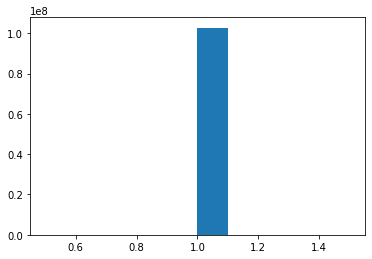

In [6]:
plt.hist(prediction.flatten())

(array([8.9230431e+07, 2.9375000e+04, 2.3272000e+04, 9.6350000e+03,
        8.5720000e+03, 2.0370000e+03, 1.6645000e+04, 2.7391000e+04,
        2.6044000e+04, 1.7702000e+04]),
 array([ 1. ,  2.9,  4.8,  6.7,  8.6, 10.5, 12.4, 14.3, 16.2, 18.1, 20. ]),
 <BarContainer object of 10 artists>)

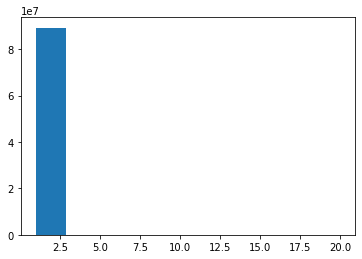

In [7]:
plt.hist(true_labels.flatten())

In [8]:
print(true_labels.shape)


(512, 512, 341)


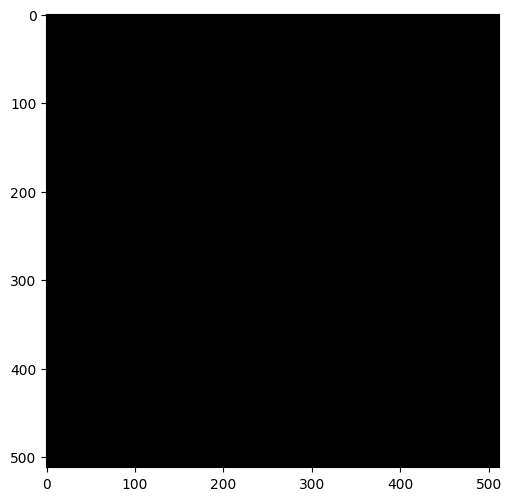

In [9]:
plt.figure(figsize = (6,6), dpi=100) 
true_img = np.max(true_labels, axis=-1)
true_img = (true_img > 0).astype(int)
plt.imshow(true_img, cmap=plt.cm.gray) 


(512, 512, 392)
(512, 512)


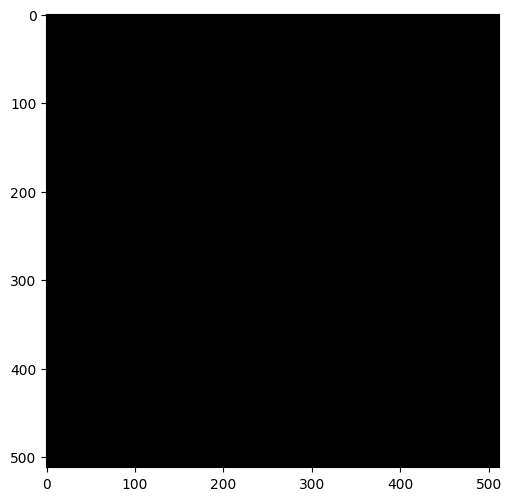

In [10]:
plt.figure(figsize = (6,6), dpi=100) 
print(prediction.shape)
combined_slices = np.max(prediction > 1, axis=-1)
print(combined_slices.shape)
plt.imshow(combined_slices, cmap=plt.cm.gray) 

In [11]:
print(true_labels.min())

1.0


In [12]:
print(true_labels.max())


20.0


In [13]:
# train_slices = exposure.equalize_hist(train_slices)

NameError: name 'train_slices' is not defined

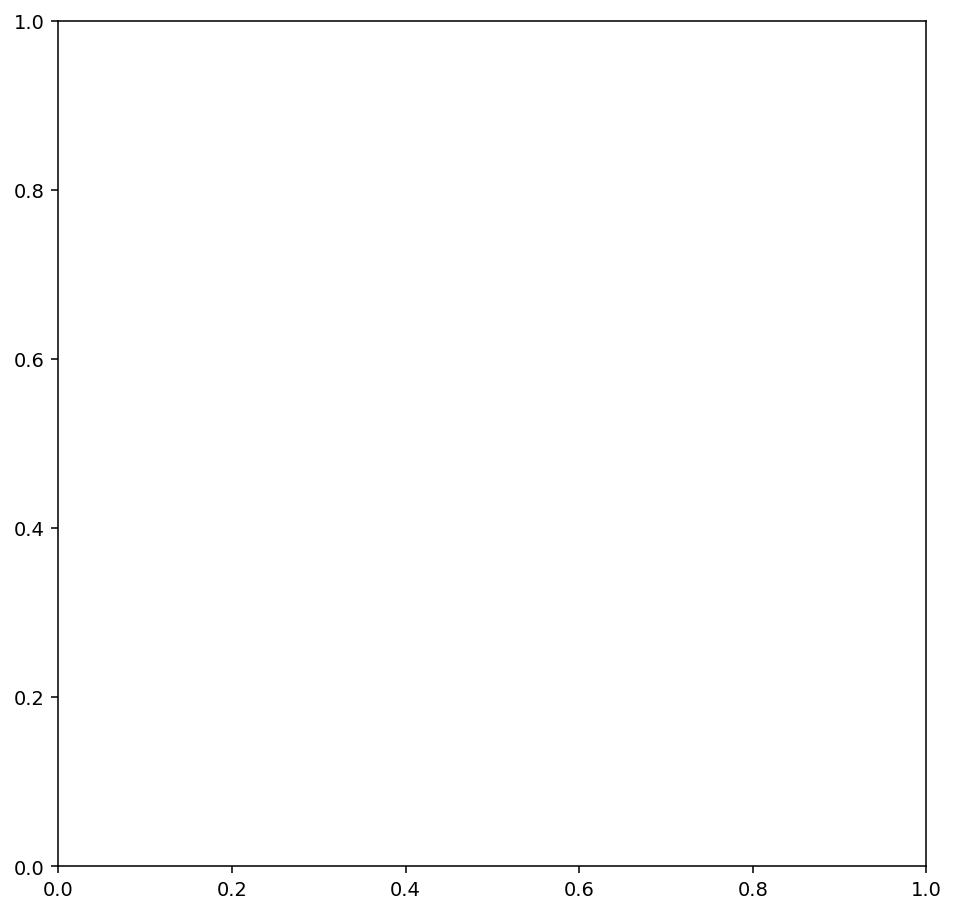

In [14]:
fig, ax = plt.subplots(figsize = (8,8), dpi=140)
ax.imshow(train_slices[100], cmap=plt.cm.gray)
ax.set_axis_off()

In [ ]:
fig, ax = plt.subplots(figsize = (8,8), dpi=140)
ax.imshow(train_slices[0], cmap=plt.cm.gray)
masked = np.ma.masked_where(label_slices[0] == 2, label_slices[0])
ax.imshow(masked, cmap='jet', alpha=0.2) 
ax.set_axis_off()

In [ ]:
fig, ax = plt.subplots(figsize = (8,8), dpi=140)
ax.imshow(train_slices[20], cmap=plt.cm.gray)

masked = np.ma.masked_where(label_slices[20] == 1, label_slices[10])
ax.imshow(masked, cmap='jet', alpha=0.3) 
ax.set_axis_off()